In [2]:
import warnings

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.style as mpstyle
from matplotlib.ticker import ScalarFormatter
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.patches import Patch, Rectangle
import pandas as pd
import geopandas as gpd
from osgeo import ogr
import cartopy.crs as ccrs
from shapely.geometry import LineString
import pickle

from tathu.io import pgis
from tathu import visualizer
from tathu.geometry.transform import ogr2shapely
from tathu.geometry.utils import fitEllipse, extractCoordinates2NumpyArray

mpstyle.use("seaborn-whitegrid")

ogr.UseExceptions()

In [3]:
# Load family
# db = spatialite.Loader(dbname, table)
db = pgis.Loader("localhost", "goamazon_geo", "camilacl", "mydb0610", "systems_filtered")
db_full = pgis.Loader("localhost", "goamazon_geo", "camilacl", "mydb0610", "systems")
# Get systems
names = db.loadNames()
names_full = db_full.loadNames()
print(len(names))
print(len(names_full))

5976
91613


## Verificando famílias muito longas

Duração maior que 12h

In [ ]:
query = '''SELECT name, elapsed_time FROM
        (SELECT name, EXTRACT(epoch FROM (max(date_time) - min(date_time)))/60/60 AS elapsed_time
        FROM systems_filtered GROUP BY name) AS duration WHERE elapsed_time >= 8 ORDER BY elapsed_time DESC'''
fams = [q[0] for q in db.query(query)]
print(len(fams))
durations = [q[1] for q in db.query(query)]
print(len(durations))

In [ ]:
fams[:5]

In [ ]:
durations[:5]

## Verificando repetição de nomes

Intervalo entre timestamps maior que o máximo permitido (60 min)

In [ ]:
query = '''SELECT name, diff
    FROM (SELECT name, (DATE_PART('day', date_time - lag(date_time) over (partition by name order by date_time)) * 24 +
    DATE_PART('hour', date_time - lag(date_time) over (partition by name order by date_time)) * 60 +
    DATE_PART('minute', date_time - lag(date_time) over (partition by name order by date_time))) AS diff FROM systems) AS diiff WHERE diff > 60'''
fams = [q[0] for q in db.query(query)]
diff = [q[1] for q in db.query(query)]
print(len(fams))

In [ ]:
fams

In [ ]:
diff

## Verificando famílias muito curtas (1 step) sem relações
Duração de 1 step, status de `SPONTANEUOS_GENERATION` e não estando em `relations`

In [ ]:
query = '''SELECT name, cc FROM (SELECT name, COUNT(*) AS cc FROM systems GROUP BY name) AS ccc WHERE cc = 1'''
fams = [q[0] for q in db.query(query)]
cc = [q[1] for q in db.query(query)]
print(len(fams))

In [ ]:
query = "SELECT name, event FROM systems WHERE name IN " + "('" + "','".join(fams) + "') AND event = 'SPONTANEOUS_GENERATION'"
qq = [q[0] for q in db.query(query)]
print(len(qq))

In [ ]:
query = (
    "SELECT name, relations FROM systems "
    + "WHERE relations IN "
    + "(ARRAY['" + "'],ARRAY['".join(qq) + "'])"
)
names = [q[0] for q in db.query(query)]
rels = [q[1] for q in db.query(query)]
print(len(rels))

In [ ]:
rels[:5]

## Extraindo dados para estatísticas

- `count`
- `duration`
- `max`, `mean`
- `event`
- `date_time`
- `gld`
- `geom`

In [4]:
# From systems_filtered

query = '''SELECT count FROM systems_filtered'''
areas = [q[0] for q in db.query(query)]
print(len(areas))

query = '''SELECT MAX(count) FROM systems_filtered GROUP BY name'''
max_areas = [q[0] for q in db.query(query)]
print(len(max_areas))

query = '''SELECT elapsed_time FROM
        (SELECT name, EXTRACT(epoch FROM (max(date_time) - min(date_time))/60) AS elapsed_time
        FROM systems_filtered GROUP BY name) AS duration'''
durations = [q[0] for q in db.query(query)]
print(len(durations))

query = '''SELECT max FROM systems_filtered'''
zmax = [q[0] for q in db.query(query)]
print(len(zmax))

query = '''SELECT mean FROM systems_filtered'''
zmean = [q[0] for q in db.query(query)]
print(len(zmean))

query = '''SELECT event FROM systems_filtered'''
event = [q[0] for q in db.query(query)]
print(len(event))

query = '''SELECT date_time FROM systems_filtered'''
timestamp = [q[0] for q in db.query(query)]
print(len(timestamp))

query = '''SELECT gld FROM systems_filtered'''
gld = [q[0] for q in db.query(query)]
print(len(gld))

query = '''SELECT DISTINCT ON (name) ST_AsBinary(geom) as wkb FROM systems_filtered ORDER BY name, date_time ASC'''
first_geoms = [ogr.CreateGeometryFromWkb(bytes(q[0])) for q in db.query(query)]
print(len(first_geoms))

query = '''SELECT DISTINCT ON (name) date_time FROM systems_filtered ORDER BY name, date_time ASC'''
first_dates = [q[0] for q in db.query(query)]
print(len(first_dates))

query = '''SELECT name, ST_AsBinary(geom) as wkb FROM systems_filtered'''
geoms_names = [q[0] for q in db.query(query)]
geoms = [ogr.CreateGeometryFromWkb(bytes(q[1])) for q in db.query(query)]
print(len(geoms))

query = '''SELECT echotop_0, echotop_20, echotop_40 FROM systems_filtered'''
echo0 = [q[0] for q in db.query(query)]
print(len(echo0))
echo20 = [q[1] for q in db.query(query)]
print(len(echo20))
echo40 = [q[2] for q in db.query(query)]
print(len(echo40))

40394
5976
5976
40394
40394
40394
40394
40394
5976
5976
40394
40394
40394
40394


In [5]:
# From systems

query = (
    "SELECT count FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a')"
)
areas_full = [q[0] for q in db_full.query(query)]
print(len(areas_full))

query = (
    "SELECT MAX(count) FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') GROUP BY name"
)
max_areas_full = [q[0] for q in db_full.query(query)]
print(len(max_areas_full))

query = (
    "SELECT elapsed_time FROM (SELECT name, EXTRACT(epoch FROM (max(date_time)"
    " - min(date_time))/60) AS elapsed_time FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') GROUP BY name) AS duration"
)
durations_full = [q[0] for q in db_full.query(query)]
print(len(durations_full))

query = (
    "SELECT max FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a')"
)
zmax_full = [q[0] for q in db_full.query(query)]
print(len(zmax_full))

query = (
    "SELECT mean FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a')"
)
zmean_full = [q[0] for q in db_full.query(query)]
print(len(zmean_full))

query = (
    "SELECT event FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a')"
)
event_full = [q[0] for q in db_full.query(query)]
print(len(event_full))

query = (
    "SELECT date_time FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a')"
)
timestamp_full = [q[0] for q in db_full.query(query)]
print(len(timestamp_full))

query = (
    "SELECT DISTINCT ON (name) date_time FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') ORDER BY name, date_time ASC"
)
first_dates_full = [q[0] for q in db_full.query(query)]
print(len(first_dates_full))


322896
91609
91609
322896
322896
322896
322896
91609


### Convertendo para um df do Pandas e plotando

In [8]:
# From systems_filtered
systems_all = pd.DataFrame({"area": areas, "max": zmax, "mean": zmean, "event": event, "timestamp": timestamp, "gld": gld, "geom_name": geoms_names, "geom": geoms, "echotop_0": echo0, "echotop_20": echo20, "echotop_40": echo40})
systems_all.timestamp = systems_all.timestamp.dt.tz_localize("UTC")
systems_all.timestamp = systems_all.timestamp.dt.tz_convert('America/Manaus')
systems_all[["echotop_0", "echotop_20", "echotop_40"]] = systems_all[["echotop_0", "echotop_20", "echotop_40"]].astype(int)
systems_per = pd.DataFrame({"max_area": max_areas, "duration": [float(dur)/60 for dur in durations], "geom": first_geoms, "timestamp": first_dates})
systems_per.timestamp = systems_per.timestamp.dt.tz_localize("UTC")
systems_per.timestamp = systems_per.timestamp.dt.tz_convert('America/Manaus')

# From systems
systems_all_full = pd.DataFrame({"area": areas_full, "max": zmax_full, "mean": zmean_full, "event": event_full, "timestamp": timestamp_full})
systems_all_full.timestamp = systems_all_full.timestamp.dt.tz_localize("UTC")
systems_all_full.timestamp = systems_all_full.timestamp.dt.tz_convert('America/Manaus')
systems_per_full = pd.DataFrame({"max_area": max_areas_full, "duration": [float(dur)/60 for dur in durations_full], "timestamp": first_dates_full})
systems_per_full.timestamp = systems_per_full.timestamp.dt.tz_localize("UTC")
systems_per_full.timestamp = systems_per_full.timestamp.dt.tz_convert('America/Manaus')

# Plot labels
class_labels = ["SPONTANEOUS\nGENERATION", "CONTINUITY", "SPLIT", "MERGE"]
time_ticks = pd.date_range(start="2014-01-01", end="2015-12-31", freq="1M")
time_labels = time_ticks.strftime("%b %Y")
time_ticks_2 = pd.date_range(start="00:00", end="23:00", freq="1H")
time_labels_2 = time_ticks_2.strftime("%H:%M")
custom_legend = [Patch(facecolor="w", edgecolor="k", label="Raw"),
                Patch(facecolor="k", edgecolor="k", label="Filtered")]
custom_legend_all = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all)) + ")")]
custom_legend_per = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per)) + ")")]

### Area

In [ ]:
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_area = systems_all_full.area.plot.hist(bins=range(0, 63000, 1000), grid=True, color="w", edgecolor="k", ax=ax1)
systems_all.area.plot.hist(bins=range(0, 63000, 1000), grid=True, color="k", edgecolor="k", ax=ax1)
ax_area.set_yscale("log")
# ax_area.yaxis.set_major_formatter(ScalarFormatter())
ax_area.set_ylim(bottom=1)
ax_area.set_ylabel("Count")
ax_area.set_title("Area of Clusters")
ax_area.legend(handles=custom_legend)

ax2 = fig.add_subplot(gs[1,0])
ax_area2 = systems_per_full.max_area.plot.hist(bins=range(0, 63000, 1000), grid=True, color="w", edgecolor="k", ax=ax2)
systems_per.max_area.plot.hist(bins=range(0, 63000, 1000), grid=True, color="k", edgecolor="k", ax=ax2)
ax_area2.set_yscale("log")
# ax_area2.yaxis.set_major_formatter(ScalarFormatter())
ax_area2.set_ylim(bottom=1)
ax_area2.set_xlabel("km²")
ax_area2.set_ylabel("Count")
ax_area2.set_title("Max Area of Convective Systems")
ax_area2.legend(handles=custom_legend)

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_area.png", dpi=300, facecolor="none")

### Refletividade média/máxima

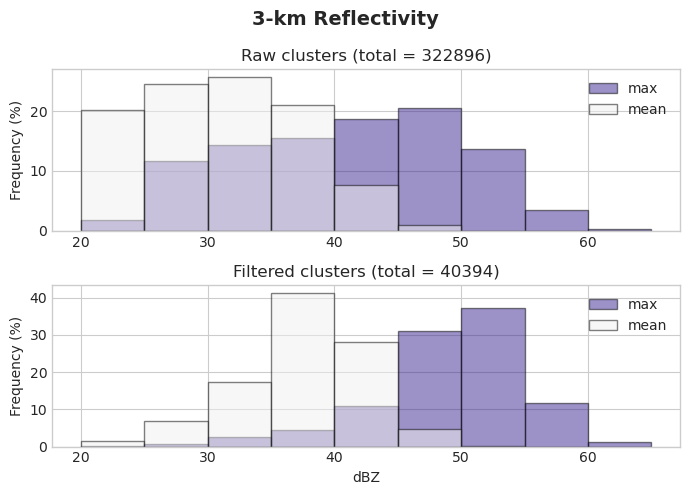

In [26]:
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_maxmean = systems_all_full[["max", "mean"]].plot.hist(bins=range(20, 70, 5), grid=True, weights=np.ones(len(systems_all_full))/len(systems_all_full)*100, color=("#3C2692","#F1F1F1"), edgecolor="k", alpha=.5, ax=ax1)
ax_maxmean.set_title("Raw clusters (total = " + str(len(systems_all_full)) + ")")
ax_maxmean.set_ylabel("Frequency (%)")

ax2 = fig.add_subplot(gs[1,0])
ax_maxmean = systems_all[["max", "mean"]].plot.hist(bins=range(20, 70, 5), grid=True, weights=np.ones(len(systems_all))/len(systems_all)*100, color=("#3C2692","#F1F1F1"), edgecolor="k", alpha=.5, ax=ax2)
ax_maxmean.set_title("Filtered clusters (total = " + str(len(systems_all)) + ")")
ax_maxmean.set_ylabel("Frequency (%)")
ax_maxmean.set_xlabel("dBZ")

fig.suptitle("3-km Reflectivity", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_z.png", dpi=300, facecolor="none")

### Classificação

In [ ]:
classes = pd.DataFrame({"full": (systems_all_full["event"].value_counts()/len(systems_all_full)*100),
                        "no-full": (systems_all["event"].value_counts()/len(systems_all)*100)}).reindex(index=["SPONTANEOUS_GENERATION", "CONTINUITY", "SPLIT", "MERGE"])

fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

ax = fig.add_subplot(gs[0,0])
ax_class = classes.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax)
ax.bar_label(ax.containers[0], fmt="%.0f")
ax.bar_label(ax.containers[1], fmt="%.0f")
ax_class.grid(axis="x")
ax_class.set_xticks(ticks=range(4), labels=class_labels, rotation=0)
ax_class.set_ylabel("Frequency (%)")
ax_class.set_ylim(top=80)
ax_class.set_title("Clusters Classification", fontweight="bold")
ax_class.legend(handles=custom_legend_all)

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_class.png", dpi=300, facecolor="none")

### Duração

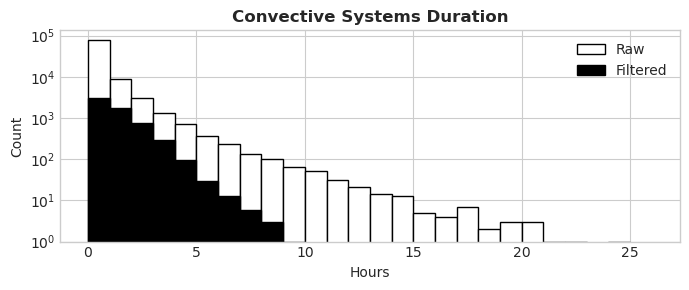

In [10]:
fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

ax5 = fig.add_subplot(gs[0,0])
ax_dur = systems_per_full.duration.plot.hist(bins=range(0, 27), grid=True, color="w", edgecolor="k", ax=ax5)
systems_per.duration.plot.hist(bins=range(0, 27), grid=True, color="k", edgecolor="k", ax=ax5)
ax_dur.set_yscale("log")
# ax_dur.yaxis.set_major_formatter(ScalarFormatter())
ax_dur.set_ylim(bottom=1)
ax_dur.set_ylabel("Count")
ax_dur.set_xlabel("Hours")
ax_dur.set_title("Convective Systems Duration", fontweight="bold")
ax_dur.legend(handles=custom_legend)

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_dur.png", dpi=300, facecolor="none")

### Clusters por mês

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
custom_legend_all2 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all)) + ")"),
                Patch(facecolor="dodgerblue", edgecolor="dodgerblue", label="Wet season"),
                Patch(facecolor="red", edgecolor="red", label="Dry season")]

monthly = pd.DataFrame({"full": (systems_all_full.resample("1M", on="timestamp").count().timestamp/len(systems_all_full)*100),
                        "no-full": (systems_all.resample("1M", on="timestamp").count().timestamp/len(systems_all)*100)})

fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = monthly.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
# Wet/dry season bars
ax_time.axvspan(-0.5, 2.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(6.5, 9.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(11.5, 14.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(18.5, 21.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
# IOPs lines/labels
ax_time.axvline([0.5], color="k", linestyle="--")
ax_time.axvline([2.5], color="k", linestyle="--")
ax_time.axvline([7], color="k", linestyle="--")
ax_time.axvline([9], color="k", linestyle="--")
ax_time.text(x=1.5, y=8, s="IOP1", fontweight="bold", ha="center")
ax_time.text(x=8, y=8, s="IOP2", fontweight="bold", ha="center")
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("Monthly distribution of clusters", fontweight="bold")
ax_time.legend(handles=custom_legend_all2, ncol=2, columnspacing=0.8, loc='upper left', bbox_to_anchor=(0.38, 1))

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_monthly.png", dpi=300, facecolor="none")

### Clusters ao lonog do dia, por estação

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_full_wet = systems_all_full.loc[systems_all_full["timestamp"].dt.month.isin([1,2,3])]
systems_all_wet = systems_all.loc[systems_all["timestamp"].dt.month.isin([1,2,3])]
systems_all_full_dry = systems_all_full.loc[systems_all_full["timestamp"].dt.month.isin([8,9,10])]
systems_all_dry = systems_all.loc[systems_all["timestamp"].dt.month.isin([8,9,10])]
systems_all_full_drytowet = systems_all_full.loc[systems_all_full["timestamp"].dt.month.isin([11,12])]
systems_all_drytowet = systems_all.loc[systems_all["timestamp"].dt.month.isin([11,12])]

custom_legend_all_wet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_wet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_wet)) + ")")]
custom_legend_all_dry = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_dry)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_dry)) + ")")]
custom_legend_all_drytowet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_drytowet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_drytowet)) + ")")]

hourly_wet = pd.DataFrame({"full": (systems_all_full_wet.groupby(systems_all_full_wet.timestamp.dt.hour).count().timestamp/len(systems_all_full_wet)*100),
                        "no-full": (systems_all_wet.groupby(systems_all_wet.timestamp.dt.hour).count().timestamp/len(systems_all_wet)*100)})
hourly_dry = pd.DataFrame({"full": (systems_all_full_dry.groupby(systems_all_full_dry.timestamp.dt.hour).count().timestamp/len(systems_all_full_dry)*100),
                        "no-full": (systems_all_dry.groupby(systems_all_dry.timestamp.dt.hour).count().timestamp/len(systems_all_dry)*100)})
hourly_drytowet = pd.DataFrame({"full": (systems_all_full_drytowet.groupby(systems_all_full_drytowet.timestamp.dt.hour).count().timestamp/len(systems_all_full_drytowet)*100),
                        "no-full": (systems_all_drytowet.groupby(systems_all_drytowet.timestamp.dt.hour).count().timestamp/len(systems_all_drytowet)*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_dry.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("Dry Season")
ax_time.legend(handles=custom_legend_all_dry, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_drytowet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("Dry-to-Wet Season")
ax_time2.legend(handles=custom_legend_all_drytowet, loc='upper left')

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_wet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax3)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("Wet Season")
ax_time3.legend(handles=custom_legend_all_wet, loc='upper left')

fig.suptitle("Hourly distribution of clusters", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_hourly.png", dpi=300, facecolor="none")

### Clusters ao longo do dia, por IOP

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_full_iop1 = systems_all_full.loc[(systems_all_full["timestamp"].dt.month.isin([2,3])) & (systems_all_full["timestamp"].dt.year == 2014)]
systems_all_iop1 = systems_all.loc[(systems_all["timestamp"].dt.month.isin([2,3])) & (systems_all["timestamp"].dt.year == 2014)]
systems_all_full_iop2 = systems_all_full.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()
systems_all_iop2 = systems_all.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()

custom_legend_all_iop1 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_iop1)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_iop1)) + ")")]
custom_legend_all_iop2 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_iop2)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_iop2)) + ")")]

hourly_iop1 = pd.DataFrame({"full": (systems_all_full_iop1.groupby(systems_all_full_iop1.timestamp.dt.hour).count().timestamp/len(systems_all_full_iop1)*100),
                        "no-full": (systems_all_iop1.groupby(systems_all_iop1.timestamp.dt.hour).count().timestamp/len(systems_all_iop1)*100)})
hourly_ìop2 = pd.DataFrame({"full": (systems_all_full_iop2.groupby(systems_all_full_iop2.timestamp.dt.hour).count().timestamp/len(systems_all_full_iop2)*100),
                        "no-full": (systems_all_iop2.groupby(systems_all_iop2.timestamp.dt.hour).count().timestamp/len(systems_all_iop2)*100)})

fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_iop1.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("IOP1 (Wet Season)")
ax_time.legend(handles=custom_legend_all_iop1, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_ìop2.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("Local Time")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("IOP2 (Dry Season)")
ax_time2.legend(handles=custom_legend_all_iop2, loc='upper left')

fig.suptitle("Hourly distribution of clusters", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_hourly_iops.png", dpi=300, facecolor="none")

### Início dos SCs, por estação

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_per_full_wet = systems_per_full.loc[systems_per_full["timestamp"].dt.month.isin([1,2,3])]
systems_per_wet = systems_per.loc[systems_per["timestamp"].dt.month.isin([1,2,3])]
systems_per_full_dry = systems_per_full.loc[systems_per_full["timestamp"].dt.month.isin([8,9,10])]
systems_per_dry = systems_per.loc[systems_per["timestamp"].dt.month.isin([8,9,10])]
systems_per_full_drytowet = systems_per_full.loc[systems_per_full["timestamp"].dt.month.isin([11,12])]
systems_per_drytowet = systems_per.loc[systems_per["timestamp"].dt.month.isin([11,12])]

custom_legend_per_wet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_wet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_wet)) + ")")]
custom_legend_per_dry = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_dry)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_dry)) + ")")]
custom_legend_per_drytowet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_drytowet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_drytowet)) + ")")]

hourly_wet = pd.DataFrame({"full": (systems_per_full_wet.groupby(systems_per_full_wet.timestamp.dt.hour).count().timestamp/len(systems_per_full_wet)*100),
                        "no-full": (systems_per_wet.groupby(systems_per_wet.timestamp.dt.hour).count().timestamp/len(systems_per_wet)*100)})
hourly_dry = pd.DataFrame({"full": (systems_per_full_dry.groupby(systems_per_full_dry.timestamp.dt.hour).count().timestamp/len(systems_per_full_dry)*100),
                        "no-full": (systems_per_dry.groupby(systems_per_dry.timestamp.dt.hour).count().timestamp/len(systems_per_dry)*100)})
hourly_drytowet = pd.DataFrame({"full": (systems_per_full_drytowet.groupby(systems_per_full_drytowet.timestamp.dt.hour).count().timestamp/len(systems_per_full_drytowet)*100),
                        "no-full": (systems_per_drytowet.groupby(systems_per_drytowet.timestamp.dt.hour).count().timestamp/len(systems_per_drytowet)*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_dry.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("Dry Season")
ax_time.legend(handles=custom_legend_per_dry, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_drytowet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("Dry-to-Wet Season")
ax_time2.legend(handles=custom_legend_per_drytowet, loc='upper left')

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_wet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax3)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("Wet Season")
ax_time3.legend(handles=custom_legend_per_wet, loc='upper left')

fig.suptitle("Convective systems initiation time", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_init.png", dpi=300, facecolor="none")

### Início dos SCs, por IOP

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_per_full_iop1 = systems_per_full.loc[(systems_per_full["timestamp"].dt.month.isin([2,3])) & (systems_per_full["timestamp"].dt.year == 2014)]
systems_per_iop1 = systems_per.loc[(systems_per["timestamp"].dt.month.isin([2,3])) & (systems_per["timestamp"].dt.year == 2014)]
systems_per_full_iop2 = systems_per_full.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()
systems_per_iop2 = systems_per.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()

custom_legend_per_iop1 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_iop1)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_iop1)) + ")")]
custom_legend_per_iop2 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_iop2)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_iop2)) + ")")]

hourly_iop1 = pd.DataFrame({"full": (systems_per_full_iop1.groupby(systems_per_full_iop1.timestamp.dt.hour).count().timestamp/len(systems_per_full_iop1)*100),
                        "no-full": (systems_per_iop1.groupby(systems_per_iop1.timestamp.dt.hour).count().timestamp/len(systems_per_iop1)*100)})
hourly_ìop2 = pd.DataFrame({"full": (systems_per_full_iop2.groupby(systems_per_full_iop2.timestamp.dt.hour).count().timestamp/len(systems_per_full_iop2)*100),
                        "no-full": (systems_per_iop2.groupby(systems_per_iop2.timestamp.dt.hour).count().timestamp/len(systems_per_iop2)*100)})

fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_iop1.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("IOP1 (Wet Season)")
ax_time.legend(handles=custom_legend_per_iop1, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_ìop2.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("Local Time")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("IOP2 (Dry Season)")
ax_time2.legend(handles=custom_legend_per_iop2, loc='upper left')

fig.suptitle("Convective systems initiation time", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_init_iops.png", dpi=300, facecolor="none")

### GLM: organizar em paineis com outras variáveis

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
custom_legend_all2 = [Patch(facecolor="k", edgecolor="k", label=str(int(systems_all.gld.sum())) + " strokes"),
                Patch(facecolor="dodgerblue", edgecolor="dodgerblue", label="Wet season"),
                Patch(facecolor="red", edgecolor="red", label="Dry season")]

monthly = pd.DataFrame({"no-full": (systems_all.resample("1M", on="timestamp").sum().gld/systems_all.gld.sum())})

fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = monthly.plot(kind="bar", color=["k"], edgecolor="k", ax=ax1)
ax_time.axvspan(-0.5, 2.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(6.5, 9.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(11.5, 14.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(18.5, 21.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvline([0.5], color="k", linestyle="--")
ax_time.axvline([2.5], color="k", linestyle="--")
ax_time.axvline([7], color="k", linestyle="--")
ax_time.axvline([9], color="k", linestyle="--")
ax_time.text(x=1.5, y=0.175, s="IOP1", fontweight="bold", ha="center")
ax_time.text(x=8, y=0.175, s="IOP2", fontweight="bold", ha="center")
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels)
ax_time.set_ylabel("Frequency")
ax_time.set_title("Monthly distribution of GLD strokes")
ax_time.legend(handles=custom_legend_all2, loc='upper left', bbox_to_anchor=(0.61, 1))

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_gld_monthly.png", dpi=300, facecolor="none")

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_wet = systems_all.loc[systems_all["timestamp"].dt.month.isin([1,2,3])]
systems_all_dry = systems_all.loc[systems_all["timestamp"].dt.month.isin([8,9,10])]
systems_all_drytowet = systems_all.loc[systems_all["timestamp"].dt.month.isin([11,12])]

custom_legend_all_wet = [Patch(facecolor="k", edgecolor="k", label=str(int(systems_all_wet.gld.sum())) + " strokes")]
custom_legend_all_dry = [Patch(facecolor="k", edgecolor="k", label=str(int(systems_all_dry.gld.sum())) + " strokes")]
custom_legend_all_drytowet = [Patch(facecolor="k", edgecolor="k", label=str(int(systems_all_drytowet.gld.sum())) + " strokes")]

hourly_wet = pd.DataFrame({"no-full": (systems_all_wet.groupby(systems_all_wet.timestamp.dt.hour).sum().gld/systems_all_wet.gld.sum())})
hourly_dry = pd.DataFrame({"no-full": (systems_all_dry.groupby(systems_all_dry.timestamp.dt.hour).sum().gld/systems_all_dry.gld.sum())})
hourly_drytowet = pd.DataFrame({"no-full": (systems_all_drytowet.groupby(systems_all_drytowet.timestamp.dt.hour).sum().gld/systems_all_drytowet.gld.sum())})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_dry.plot(kind="bar", color=["k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency")
ax_time.set_title("Dry Season")
ax_time.legend(handles=custom_legend_all_dry, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_drytowet.plot(kind="bar", color=["k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency")
ax_time2.set_title("Dry-to-Wet Season")
ax_time2.legend(handles=custom_legend_all_drytowet, loc='upper left')

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_wet.plot(kind="bar", color=["k"], edgecolor="k", ax=ax3)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency")
ax_time3.set_title("Wet Season")
ax_time3.legend(handles=custom_legend_all_wet, loc='upper left')

fig.suptitle("Hourly distribution of strokes", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_gld_init.png", dpi=300, facecolor="none")

### Geoms: mapa com início e trajetórias

In [ ]:
systems_per.geom = [ogr2shapely(g) for g in systems_per.geom]
systems_geom = gpd.GeoDataFrame(systems_per, geometry="geom").set_crs('EPSG:3395')
systems_geom["point"] = systems_geom.geometry.to_crs("EPSG:3857").centroid.to_crs("EPSG:3395")
systems_geom

In [ ]:
rivers = gpd.read_file("/home/camilacl/git/amazon-storms-aerosols/data/general/shapefiles/ne_10m_rivers_lake_centerlines.shp").to_crs("EPSG:3395")
rivers

In [ ]:
systems_geom.loc[(systems_geom["timestamp"].dt.year == 2015) & (systems_geom["timestamp"].dt.month == 1)].geom.plot(facecolor="none")

In [ ]:
plt.clf()

In [ ]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
months_names = ["Jan", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig = plt.figure(figsize=(10,15))
gs = fig.add_gridspec(4,3)

for month, name in zip(months, months_names):
    ax = fig.add_subplot(gs[month-1])
    ax_plt = systems_geom.loc[(systems_geom["timestamp"].dt.year == 2014) & (systems_geom["timestamp"].dt.month == month)].geom.plot(facecolor="none", linewidth=0.5, ax=ax)
    ax_plt.set_xlim((-61.5, -58.5))
    ax_plt.set_ylim((-4.5, -1.5))
    ax_plt.set_xlabel("Longitude (°)")
    ax_plt.set_ylabel("Latitude (°)")
    rivers.plot(ax=ax)
    ax_plt.set_title(name + " 2014 - " + str(systems_geom.loc[(systems_geom["timestamp"].dt.year == 2014) & (systems_geom["timestamp"].dt.month == month)].geom.count()) + " CSs")

fig.suptitle("Convective Systems Initiation", size=14, fontweight="bold")

gs.tight_layout(fig)

fig = plt.figure(figsize=(10,15))
gs = fig.add_gridspec(4,3)

for month, name in zip(months, months_names):
    ax = fig.add_subplot(gs[month-1])
    ax_plt = systems_geom.loc[(systems_geom["timestamp"].dt.year == 2015) & (systems_geom["timestamp"].dt.month == month)].geom.plot(facecolor="none", linewidth=0.5, ax=ax)
    ax_plt.set_xlim((-61.5, -58.5))
    ax_plt.set_ylim((-4.5, -1.5))
    ax_plt.set_xlabel("Longitude (°)")
    ax_plt.set_ylabel("Latitude (°)")
    rivers.plot(ax=ax)
    ax_plt.set_title(name + " 2015 - " + str(systems_geom.loc[(systems_geom["timestamp"].dt.year == 2015) & (systems_geom["timestamp"].dt.month == month)].geom.count()) + " CSs")

fig.suptitle("Convective Systems Initiation", size=14, fontweight="bold")

gs.tight_layout(fig)

In [ ]:
temp = pd.DataFrame(systems_all)
temp["ellipse"] = temp.geom.apply(lambda x: fitEllipse(x))
[ellipse.CloseRings() for ellipse in temp.ellipse]
temp.ellipse = [ogr2shapely(g) for g in temp.ellipse]
clusters_geom = gpd.GeoDataFrame(temp, geometry="ellipse").set_crs('EPSG:3395')
clusters_geom["point"] = clusters_geom.ellipse.to_crs("EPSG:3857").centroid.to_crs("EPSG:3395")
clusters_geom.geom = [ogr2shapely(g) for g in clusters_geom.geom]
clusters_geom

In [ ]:
clusters_geomt = clusters_geom.groupby("geom_name").filter(lambda x : len(x)>1)
points = clusters_geomt.groupby("geom_name").point.apply(lambda x: LineString(x.tolist()[::len(x.tolist())-1]))
clusters_geom2 = gpd.GeoDataFrame(points, geometry='point').set_crs('EPSG:3395')
clusters_geom2["timestamp"] = clusters_geomt.groupby("geom_name").first().timestamp
clusters_geom2

In [ ]:
clusters_geom3 = gpd.GeoDataFrame(clusters_geom, geometry="geom").set_crs('EPSG:3395')
clusters_geom3

In [ ]:
clusters_geom2.loc[(clusters_geom2["timestamp"].dt.year == 2014) & (clusters_geom2["timestamp"].dt.month == 1)].point.plot(linewidth=0.5)

#### FAZER SETA ENTRE PTO INICIAL E FINAL
Não sei como ☹

In [ ]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,15))
gs = fig.add_gridspec(1,1)

ax = fig.add_subplot(gs[0], projection=crs)
ax_plt = systems_geom.loc[(systems_geom["timestamp"].dt.year == 2014) & (systems_geom["timestamp"].dt.month == 1)].to_crs(crs.proj4_init).point.plot(color="r", ax=ax)
clusters_geom2.loc[(clusters_geom2["timestamp"].dt.year == 2014) & (clusters_geom2["timestamp"].dt.month == 1)].point.plot(color="g", ax=ax)
# clusters_geom.loc[(clusters_geom["timestamp"].dt.year == 2014) & (clusters_geom["timestamp"].dt.month == 1) & (clusters_geom["timestamp"].dt.day == 10)].ellipse.plot(facecolor="none", ax=ax)
# clusters_geom3.loc[(clusters_geom3["timestamp"].dt.year == 2014) & (clusters_geom3["timestamp"].dt.month == 1) & (clusters_geom3["timestamp"].dt.day == 10)].geom.plot(facecolor="none", ax=ax)
ax_plt.set_xlim((-61.47, -58.5))
ax_plt.set_ylim((-4.65, -1.65))
ax_plt.set_xlabel("Longitude (°)")
ax_plt.set_ylabel("Latitude (°)")
rivers.to_crs(crs.proj4_init).plot(ax=ax)
# ax.add_geometries(rivers["geometry"].to_crs(crs.proj4_init), crs=crs)
ax.tissot(rad_km=150, lons=[-59.991,], lats=[-3.149,], n_samples=128, facecolor="none")
gl = ax.gridlines(crs=crs, draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# ax_plt.set_title(name + " 2014 - " + str(systems_geom.loc[(systems_geom["timestamp"].dt.year == 2014) & (systems_geom["timestamp"].dt.month == month)].geom.count()) + " CSs")


### Echotops, derivada de echotops

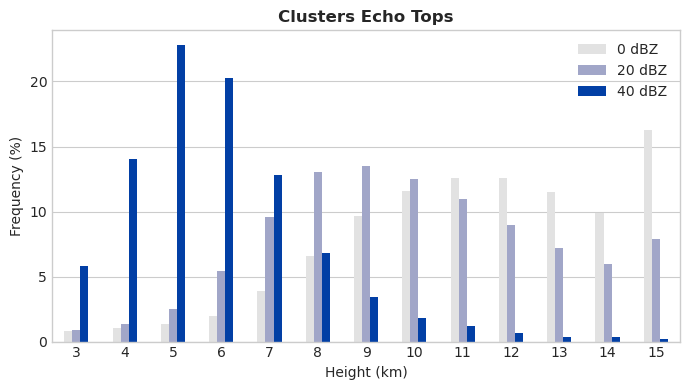

In [24]:
tops = pd.DataFrame({"0 dBZ": (systems_all["echotop_0"].value_counts()/len(systems_all)*100),
                     "20 dBZ": (systems_all["echotop_20"].value_counts()/len(systems_all)*100),
                     "40 dBZ": (systems_all["echotop_40"].value_counts()/len(systems_all)*100)}).drop(index=0)


fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax_echo = tops.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), ax=ax1)
ax_echo.grid(axis="x")
ax_echo.set_xlabel("Height (km)")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
ax_echo.set_title("Clusters Echo Tops", fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_echotops.png", dpi=300, facecolor="none")

# FALTA ARRUMAR

In [ ]:
custom_legend_all2 = [Patch(facecolor="k", edgecolor="k", label=" strokes"),
                Patch(facecolor="dodgerblue", edgecolor="dodgerblue", label="Wet season"),
                Patch(facecolor="red", edgecolor="red", label="Dry season")]

tops = pd.DataFrame({"0 dBZ": (systems_all["echotop_0"].value_counts()/len(systems_all)*100),
                     "20 dBZ": (systems_all["echotop_20"].value_counts()/len(systems_all)*100),
                     "40 dBZ": (systems_all["echotop_40"].value_counts()/len(systems_all)*100)}).drop(index=0)


fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax_echo = tops.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), ax=ax1)
ax_echo.grid(axis="x")
ax_echo.set_xlabel("Height (km)")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
ax_echo.set_title("Clusters Echo Tops", fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_echotops.png", dpi=300, facecolor="none")